In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

In [75]:
df = pd.read_csv('mnist_10000.csv')
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


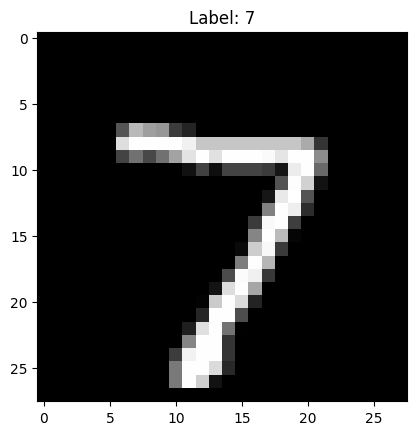

In [76]:
X = df.drop('label', axis=1).values
Y = df['label'].values

image = X[0].reshape(28,28)
plt.imshow(image, cmap='gray')
plt.title(f'Label: {Y[0]}')
plt.show()


In [77]:
class MNISTDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features) / 255.0
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = MNISTDataset(X, Y)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')

Train size: 7000, Test size: 3000


In [78]:
class MPL(nn.Module):
    def __init__(self, input_size=784, hidden_size1= 128, hidden_size2=64, num_classes=10):
        super(MPL, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPL().to(device)

print("Device:", device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')



Device: cuda
MPL(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Total parameters: 109386


In [79]:
criterion = nn.CrossEntropyLoss() # multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [80]:
class EarlyStopping:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [81]:
class ModelTrainer:
    def __init__(self, model, criterion, optimiser, device, train_loader, test_loader):
        self.model = model
        self.criterion = criterion
        self.optimiser = optimiser
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.loss_history = []
        self.val_loss_history = []

    def calculate_val_loss(self):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        return val_loss / len(self.test_loader.dataset)

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for features, labels in self.train_loader:
            features, labels = features.to(self.device), labels.to(self.device)

            self.optimiser.zero_grad()
            outputs = self.model(features)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimiser.step()

            running_loss += loss.item() * features.size(0)

        epoch_loss = running_loss / len(self.train_loader.dataset)
        self.loss_history.append(epoch_loss)
        return epoch_loss
        
    def train(self, num_epochs, early_stopping, scheduler):
        pbar = tqdm(range(num_epochs), desc='Training Progress', unit='epoch')

        for epoch in pbar:
            epoch_loss = self.train_epoch()
            val_loss = self.calculate_val_loss()
            
            self.val_loss_history.append(val_loss)

            scheduler.step(val_loss)

            pbar.set_postfix({'Train Loss': epoch_loss, 'Val Loss': val_loss})

            if early_stopping:
                early_stopping.step(val_loss)
                if early_stopping.early_stop:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        





In [82]:
trainer = ModelTrainer(model, criterion, optimizer, device, train_loader, test_loader)

num_epochs = 50
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

trainer.train(num_epochs, early_stopping, scheduler)

torch.save(model.state_dict(), 'mnist_mpl_model.pth')


Training Progress:  28%|██▊       | 14/50 [00:07<00:20,  1.77epoch/s, Train Loss=0.0233, Val Loss=0.192]

Early stopping at epoch 15


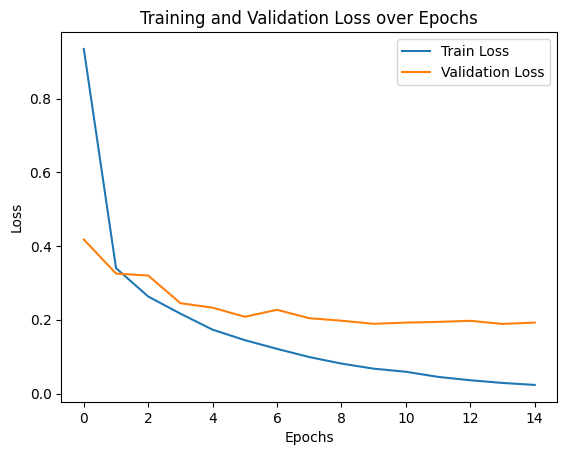

In [83]:
plt.plot(trainer.loss_history, label='Train Loss')
plt.plot(trainer.val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [84]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [85]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)

        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 94.50%


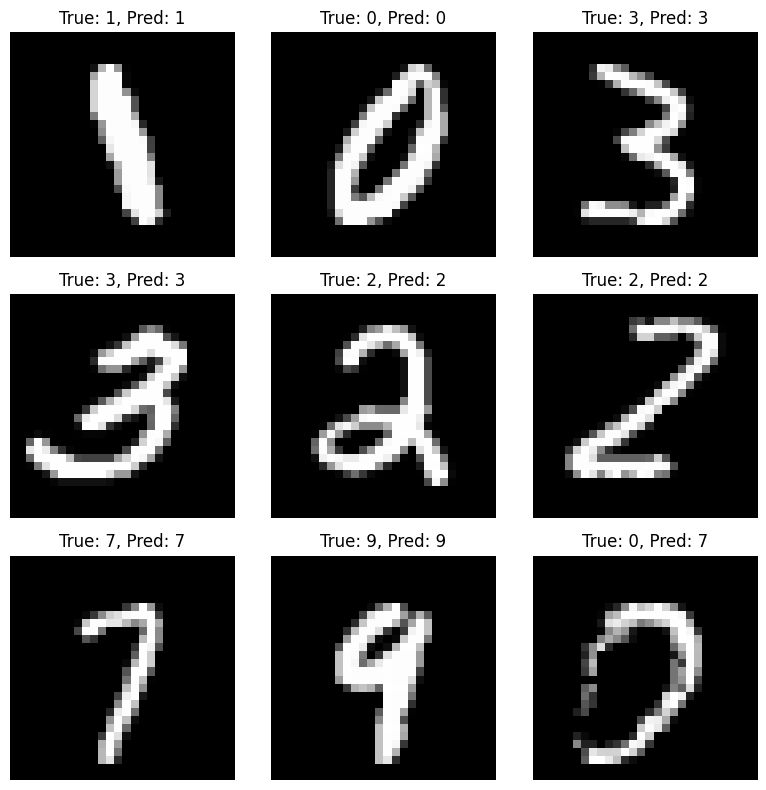

In [86]:
# Visualization of some predictions
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i < len(test_dataset):
        feature, label = test_dataset[i]
        feature = feature.to(device).unsqueeze(0)

        with torch.no_grad():
            output = model(feature)
            _, predicted = torch.max(output.data, 1)

        image = feature.cpu().numpy().reshape(28, 28)
        ax.imshow(image, cmap='gray')
        ax.set_title(f'True: {label}, Pred: {predicted.item()}')
        ax.axis('off')
plt.tight_layout()
plt.show()
        